** ** 

<figure>
<div style="text-align:center"><img src="./img/compton_setup.png" /></div>
<p><center>The experimental setup.</center></p>
</figure>

# Compton gamma-ray scattering at a 110-degree angle

** **

* This project uses the lmfit package. Lmfit provides curve fiting using non-linear least squares minimization and was developed by Matt Newville: https://github.com/newville.

## Install and import libraries

In [1]:
#uncomment the following lines to install lmfit

#from subprocess import call
# call(['pip', 'install', 'lmfit'])
# call(['pip', 'install', 'matplotlib'])
#call(['pip', 'install', 'ipympl'])

#install pymc3
#%pip install pymc3

In [2]:
#import libraries
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit.models import MoffatModel, PolynomialModel
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import matplotlib.lines as mlines
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Data Wrangling

In [3]:
#Load data

#Load channel counts of scattering from large aluminum target at 18deg
df_110 = pd.read_csv("./Data/180912-1447_Cs-137_LgHole_LgAl_110-degrees.csv")

In [4]:
#preview the data
df_110.head()

,0
0,0
1,0
2,0
3,0
4,0


In [5]:
#force start the index at 1 and add it as a column to match the channel numbers
# Set the index to start at 1
df_110.index = range(1, len(df_110) + 1)

# Add the index as the first column
df_110.insert(0, 'Channel', df_110.index)

#preview the data
df_110.head()

,Channel,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0


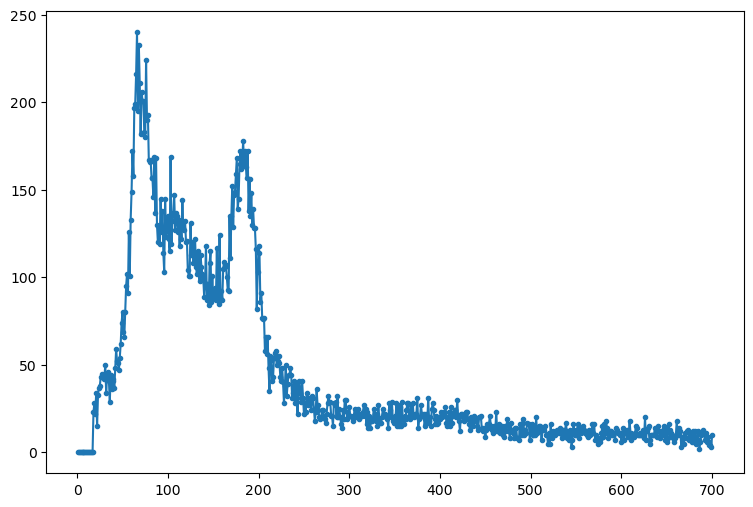

In [6]:
#preview the data 

#Uncomment the next line to make the graph interactive
#%matplotlib widget

#rename the second column
df_110.rename(columns={"0": "Counts"}, inplace=True)

#remove unnecessary data
df_110 = df_110[df_110['Channel'] <= 700]

plt.figure(figsize=(9,6))

#preview the spectrum
plt.plot('Channel', 'Counts', data = df_110, marker = ".")

plt.show()

In [7]:
# Define the channel ranges
channel_ranges = [0, 165, 200, 700]

# Create labels for the ranges
labels = [f"Range {i}-{j}" for i, j in zip(channel_ranges[:-1], channel_ranges[1:])]

# Use pd.cut() to categorize the data into the specified ranges
df_110['Channel Range'] = pd.cut(df_110['Channel'], bins=channel_ranges, labels=labels, include_lowest=True)

# Create a dictionary of DataFrames, one for each channel range
channel_range_dfs = {label: group for label, group in df_110.groupby('Channel Range')}

# Access individual DataFrames using keys (e.g., channel_range_dfs['Range 0-40'])
channel_range_dfs['Range 165-200'].head()

,Channel,Counts,Channel Range
166,166,93,Range 165-200
167,167,92,Range 165-200
168,168,135,Range 165-200
169,169,111,Range 165-200
170,170,135,Range 165-200


## Define the model, fit, and print the results

In [8]:
#use builtin model:
mod2 = MoffatModel(prefix='g2_') 

In [9]:
#initialize the parameters to be optimized
pars2  = mod2.make_params(g2_amplitude=185.0, g2_center=182.0, g2_sigma=5.84, g2_beta=1)

In [10]:
#fit with weights=1./yerr
result2 = mod2.fit(channel_range_dfs['Range 165-200']['Counts'], pars2, x = channel_range_dfs['Range 165-200']['Channel'],
                   weights = 1 / (channel_range_dfs['Range 165-200']["Channel"] * 0.066895))

#print the Fit Statistics and parameters
print('------------------------------------------------------')
print(result2.fit_report())
print('------------------------------------------------------')

------------------------------------------------------
[[Model]]
    Model(moffat, prefix='g2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1408
    # data points      = 35
    # variables        = 4
    chi-square         = 31.0030056
    reduced chi-square = 1.00009696
    Akaike info crit   = 3.75576327
    Bayesian info crit = 9.97715551
    R-squared          = 0.99853313
[[Variables]]
    g2_amplitude:  167.430273 +/- 4.04482379 (2.42%) (init = 185)
    g2_center:     182.450173 +/- 0.46782694 (0.26%) (init = 182)
    g2_sigma:      2345.67572 +/- 22641504.9 (965244.46%) (init = 5.84)
    g2_beta:       9824.57424 +/- 1.8892e+08 (1922899.10%) (init = 1)
    g2_fwhm:       39.4059220 +/- 1484.02410 (3765.99%) == '2*g2_sigma*sqrt(2**(1.0/max(1e-3, g2_beta))-1)'
    g2_height:     167.430273 +/- 4.04482379 (2.42%) == 'g2_amplitude'
[[Correlations]] (unreported correlations are < 0.100)
    C(g2_sigma, g2_beta)      = +1.0000
    C(g2_amplitude, g2_s

## Plot the model

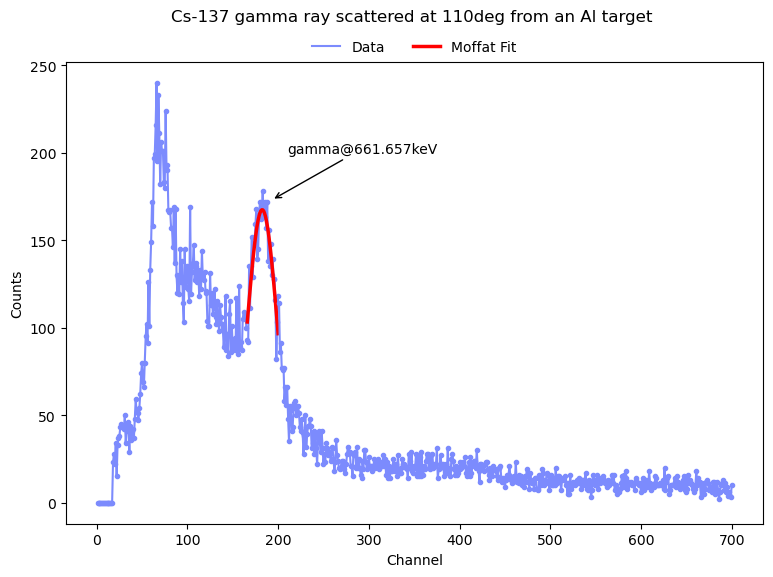

In [11]:
#Uncomment the line below to make the graph interactive
#%matplotlib widget

plt.figure(figsize=(9,6))

#plot data and models
plt.plot('Channel', 'Counts', data = channel_range_dfs['Range 0-165'], color = '#7c8bfd', marker = ".")

plt.plot('Channel', 'Counts', data = channel_range_dfs['Range 165-200'], color = '#7c8bfd', marker = ".")
plt.plot(channel_range_dfs['Range 165-200']['Channel'], result2.best_fit, 'r-', linewidth=2.5)

plt.plot('Channel', 'Counts', data = channel_range_dfs['Range 200-700'], color = '#7c8bfd', marker = ".")

plt.ylabel('Counts')
plt.xlabel('Channel')

plt.annotate('gamma@661.657keV', xy=(193, 173), xytext=(210, 200),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )


# Create legend entries for the blue and red lines (data and model) and display the legend
blue_line = mlines.Line2D([], [], color='#7c8bfd', label='Data')

red_line = mlines.Line2D([], [], color='red', label='Moffat Fit', linewidth=2.5)

plt.legend([blue_line, red_line], ['Data', 'Moffat Fit'], loc='lower center', bbox_to_anchor= (0.5, 1.005), ncol=2,
            borderaxespad=0, frameon=False)

plt.title('Cs-137 gamma ray scattered at 110deg from an Al target ', y = 1.07)

#show the plot
plt.show()

# Estimate the measured energy using the calibration curve (prepared in notebook 5) 

In [12]:
# Data
x_r = np.array([29.3812658, 70.4034958, 100.839961, 102.324468, 254.677094, 350.450834, 638.540552, 738.972592])
y_r = np.array([14.4136, 80.998, 122.060, 160.605, 356.005, 511.006, 661.6570, 1274.54])
yerr_r = np.array([0.0003, 0.008, 0.010, 0.015, 0.017, 0.008, 0.003, 0.008])

#use builtin NameModel, specify prefix for each:
mod_r1 = PolynomialModel(1, prefix='p_r1_')
mod_r2 = PolynomialModel(2, prefix='p_r2_')

#set initial parameters
pars_r1 = mod_r1.guess(y_r, x=x_r)
pars_r2 = mod_r2.guess(y_r, x=x_r)    

#fit with weights=1./yerr
result_r1 = mod_r1.fit(y_r, pars_r1, x=x_r, weights = 1. / (y_r * np.mean(yerr_r / y_r) + y_r * 0.198))
result_r2 = mod_r2.fit(y_r, pars_r2, x=x_r, weights = 1. / (y_r * np.mean(yerr_r / y_r) + y_r * 0.186))


print()
print("Linear Model Parameters")
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result_r1.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

print()
print("Linear Model Fit Stats")
print('-------------------------------')
print("Reduced Chi-squared = ", result_r1.redchi)
print("r-squared = ", result_r1.rsquared)
    
print()
print("Quadratic Model Parameters")
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result_r2.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')    

print()
print("Quadratic Model Fit Stats")
print('-------------------------------')
print("Reduced Chi-squared = ", result_r2.redchi)
print("r-squared = ", result_r2.rsquared)


Linear Model Parameters
-------------------------------
Parameter    Value       Stderr
p_r1_c0   -27.70990     4.87254
p_r1_c1     1.45191     0.12099

Linear Model Fit Stats
-------------------------------
Reduced Chi-squared =  1.0038505734658223
r-squared =  0.9999951130945643

Quadratic Model Parameters
-------------------------------
Parameter    Value       Stderr
p_r2_c0   -35.38041     7.32770
p_r2_c1     1.71396     0.22612
p_r2_c2    -0.00061     0.00046

Quadratic Model Fit Stats
-------------------------------
Reduced Chi-squared =  1.00411106030073
r-squared =  0.9999959265220606


In [13]:
#Print the new position
varys = result2.params.valuesdict()

position = varys['g2_center']

print(position)

182.45017289124942


In [14]:
print()
print("Linear model estimation")
print('----------------------------')
print(result_r1.eval(pars_r1, x = position))

print()
print("Quadratic model estimation")
print('----------------------------')
print(result_r2.eval(pars_r2, x = position))


Linear model estimation
----------------------------
245.2670132766635

Quadratic model estimation
----------------------------
218.43755038418323


## Creating a new table row by plugging the result into the Compton formula

![](./img/Compton_formula.png)

In [15]:
#extract the energy from the model 
energy = result_r2.eval(pars_r2, x = position) 

#Calculate the variables (to be compared in the last step) according to the Compton model  
x = 1 - np.cos(np.deg2rad(110))
y = 1 / (energy / 1000) #convert the energy to MeV

#Add the data to a dictionary
Compton_data = {"x" : x, "y" : y}

#Preview the created row of data
print(Compton_data)

{'x': 1.3420201433256687, 'y': 4.577967470525199}


### Append the values to a csv file

In [16]:
# import csv

# with open(r'./Data/Compton_data.csv', 'a', newline='') as csvfile:
#     fieldnames = ['x','y']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

#     writer.writerow(Compton_data)

** **

## Author

### <a href="https://www.linkedin.com/in/alin-airinei/">Alin Airinei</a>

** **